# Stage 2 - Exact Heston Model Simuations

- Here we do ...


=== Testing COS Method ===
Using cos method for CDF recovery and inversion
Computation time: 0.141 seconds

=== Testing CARR_MADAN Method ===
Using carr_madan method for CDF recovery and inversion
Computation time: 1.650 seconds

=== Testing CONV Method ===
Using conv method for CDF recovery and inversion
Computation time: 10.459 seconds


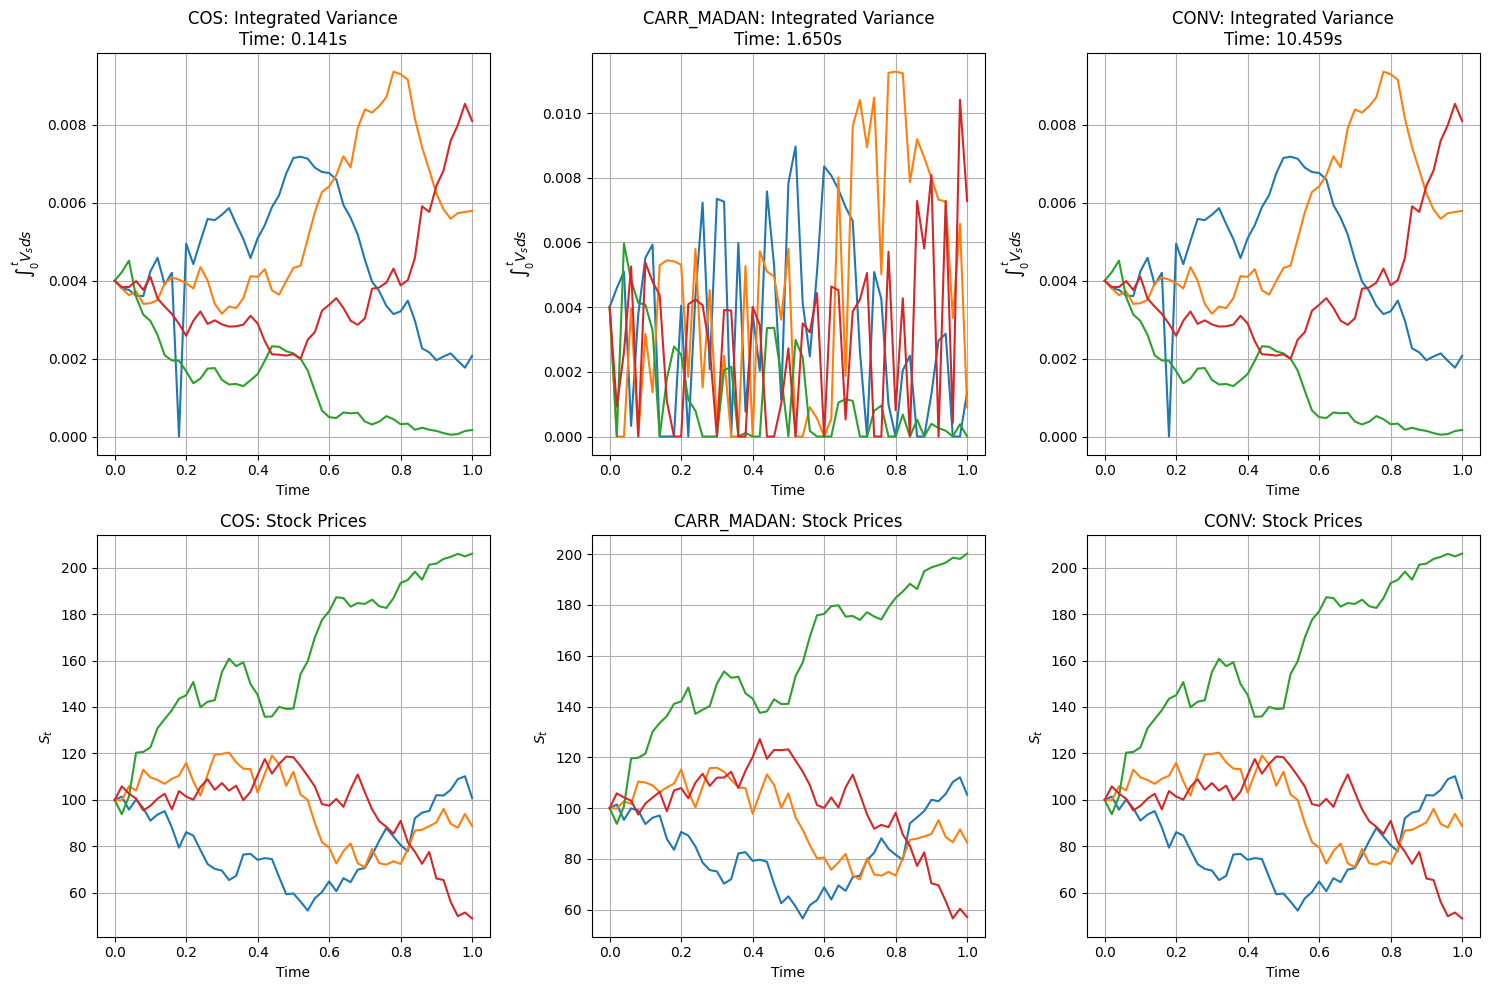


=== Performance Comparison ===
COS: 0.141 seconds
CARR_MADAN: 1.650 seconds
CONV: 10.459 seconds


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.special as ss
from scipy.stats import norm
from scipy.integrate import trapezoid
import pandas as pd

# 1.ii.b - COS CDF recovery
def cos_cdf(a, b, omega, chf, x):
    F_k = 2.0 / (b - a) * np.real(chf * np.exp(-1j * omega * a))
    cdf = np.squeeze(F_k[0] / 2.0 * (x - a)) + np.matmul(F_k[1:] / omega[1:], np.sin(np.outer(omega[1:], x - a)))
    
    return cdf

def cos_pdf(a, b, N, chf, x): # chf(omega)
    #i = np.complex(0.0, 1.0)  # assigning i=sqrt(-1)
    k = np.linspace(0, N-1, N)
    #u = np.zeros([1,N]) # Num of arguments for ch.f.
    u = k * np.pi / (b-a) # scale; frequencies -- u = omega 
    # F_k coefficients
    F_k = 2.0 / (b - a) * np.real(chf(u) * np.exp(-1j * u * a))
    F_k[0] = F_k[0] * 0.5  # first term
    # Final calculation
    pdf = np.matmul(F_k, np.cos(np.outer(u, x - a)))
    
    return pdf

# Carr-Madan
def carr_madan_cdf(chf, x_grid, u_max=200, N=2**12):
    # Starting from close to 0
    u_min = 1e-10  # Much smaller starting point to capture low-frequency behavior
    u = np.linspace(u_min, u_max, N)
    # Compute integrand for each x (unchanged)
    integrand = np.imag(np.exp(-1j * np.outer(x_grid, u)) * chf(u)) / u  # shape: (len(x), N)
    # Integrate using trapezoidal rule along frequency axis (unchanged)
    integral = trapezoid(integrand, u, axis=1)
    # Apply Gil-Pelaez inversion formula
    cdf = 0.5 - (1 / np.pi) * integral

    return np.clip(np.squeeze(cdf), 0.0, 1.0)  # Clamp in [0,1]

# Recover PDF
def carr_madan_pdf(chf, x_grid, u_max=100, N=2**12):
    du = 2 * u_max / N
    u = np.linspace(-u_max, u_max - du, N)
    # Compute integrand of inverse Fourier transform
    integrand = np.exp(-1j * np.outer(x_grid, u)) * chf(u)
    # Numerical integration using trapezoidal rule
    integral = np.trapezoid(integrand, u, axis=1)
    pdf = np.squeeze(np.real(integral) / (2 * np.pi))
    return pdf

# CONV
def conv_pdf(chf, x_range=(-5, 5), alpha=1.0, N=2**12):    
    # Step 1: Set up the grids
    x_min, x_max = x_range
    L = x_max - x_min  # Total length of spatial domain
    # Spatial and frequency grid spacings
    dx = L / N
    du = 2 * np.pi / L
    # Step 2: Create the frequency grid
    # For FFT, we need frequencies from -u_max to u_max where u_max = pi/dx
    # But FFT expects a specific ordering
    u_max = np.pi / dx  # Nyquist frequency
    # Create frequency array in "standard" order from -u_max to u_max
    if N % 2 == 0:
        # For even N: [-N/2, -N/2+1, ..., -1, 0, 1, ..., N/2-1] x du
        k = np.concatenate([np.arange(-N//2, 0), np.arange(0, N//2)])
    else:
        # For odd N: [-(N-1)/2, ..., -1, 0, 1, ..., (N-1)/2] x du
        k = np.arange(-(N-1)//2, (N+1)//2)
    u = k * du
    # Step 3: Create the spatial grid
    # Important: This grid corresponds to the FFT output ordering
    x = x_min + np.arange(N) * dx
    # Step 4: Evaluate the damped characteristic function
    # phi(u - ia) provides exponential damping for numerical stability
    phi_damped = chf(u - 1j * alpha)
    # Step 5: Prepare the integrand for FFT
    # We need to include a phase factor to account for the shift to x_min
    # The continuous transform of phi(u)e^{-iu x_min} gives f(x + x_min)
    integrand = phi_damped * np.exp(-1j * u * x_min)
    # Step 6: Apply FFT with correct ordering
    # FFT expects input in order [0, 1, ..., N/2-1, -N/2, ..., -1]
    # So we need to reorder our frequency-domain data
    integrand_fft_order = np.fft.ifftshift(integrand)
    # Step 7: Compute the FFT
    # This approximates the integral \int{ phi(u-ia) e^{-iu(x-x_min)} du }
    fft_result = np.fft.fft(integrand_fft_order)
    # Step 8: Extract and normalize the PDF
    # The factor du converts the sum to an integral
    # The factor 1/(2pi) comes from the inverse Fourier transform
    # The factor e^{-ax} removes the damping we introduced
    pdf = np.real(fft_result) * np.exp(-alpha * x) * du / (2 * np.pi)
    # Step 9: Ensure non-negativity (small numerical errors can cause negative values)
    pdf = np.maximum(pdf, 0)
    
    # Check: Normalize to ensure integral equals 1
    integral = trapezoid(pdf, x)
    if integral > 0:
        pdf = pdf / integral
    
    return x, pdf

def conv_cdf(chf, x_vals, x_range=None, alpha=0.5, N=2**13):
    # Step 1: Determine the domain for PDF recovery
    if x_range is None:
        # Automatically choose a domain that covers x_vals with some padding
        # This ensures we capture the full probability mass
        x_min_req = np.min(x_vals)
        x_max_req = np.max(x_vals)
        padding = (x_max_req - x_min_req) * 0.5  # 50% padding on each side
        x_range = (x_min_req - padding, x_max_req + padding)
    # Step 2: Recover the PDF using our existing function
    x_grid, pdf_grid = conv_pdf(chf=chf, x_range=x_range, alpha=alpha, N=N)
    # Step 3: Compute CDF on the native grid by cumulative integration
    # Using the trapezoidal rule for integration
    dx = x_grid[1] - x_grid[0]  # Grid spacing (uniform)
    cdf_grid = np.zeros_like(pdf_grid)
    # Integrate from left to right: CDF[i] = \int_{-\infty}^{x[i]} PDF(t) dt
    cdf_grid[0] = 0.0  # CDF starts at 0 at the leftmost point
    for i in range(1, len(cdf_grid)):
        # Add the area of the trapezoid between points i-1 and i
        cdf_grid[i] = cdf_grid[i-1] + 0.5 * (pdf_grid[i-1] + pdf_grid[i]) * dx
    # Alternative vectorized approach (more efficient):
    # cdf_grid = np.concatenate([[0], np.cumsum(0.5 * (pdf_grid[:-1] + pdf_grid[1:]) * dx)])
    # Step 4: Interpolate CDF to the requested x_vals
    cdf_vals = np.interp(x_vals, x_grid, cdf_grid)
    # Step 5: Ensure CDF properties are satisfied
    # CDF should be between 0 and 1, and monotonically increasing
    cdf_vals = np.clip(cdf_vals, 0.0, 1.0)
    
    return cdf_vals

def CIR_Sample(NoOfPaths, kappa, gamma, vbar, s, t, v_s):
    """ Sampling from noncentral-chiSquared distribution 
    tau = (t - s) - time to maturity, for s<t
    delta = degrees of freedom
    Squared Bessel process - delta => 2, -> unique solution + 0 is not attainable!
                           
    """
    delta = 4.0 * kappa * vbar / gamma / gamma
    c = 2 * kappa / (gamma ** 2 * (1 - np.exp(-kappa * (t - s))))
    kappaBar = 2 * c * np.exp(-kappa * (t - s)) * v_s
    sample = np.random.noncentral_chisquare(delta, kappaBar, NoOfPaths) / (2 * c)
    return sample

def ChFIntegratedVariance(omega, kappa, gamma, vbar, vu, vt, tau):
    """ Broadie-Kaya -> Exact sampling scheme (see paper) """
    R = np.sqrt(kappa ** 2 - 2.0 * gamma ** 2 * 1j * omega)
    d = 4 * kappa * vbar / gamma ** 2

    temp1 = R * np.exp(-tau / 2.0 * (R - kappa)) * (1 - np.exp(-kappa * tau)) / (kappa * (1 - np.exp(-R * tau)))

    temp2 = np.exp((vu + vt) / gamma ** 2 * (kappa * (1 + np.exp(-kappa * tau)) / (1 - np.exp(-kappa * tau)) - R * (1 + np.exp(-R * tau)) / (1 - np.exp(-R * tau))))
    
    # Bessel functions
    temp3 = ss.iv(0.5 * d - 1.0, np.sqrt(vt * vu) * 4.0 * R * np.exp(-R * tau / 2.0) / (gamma ** 2 * (1 - np.exp(-R * tau))))

    temp4 = ss.iv(0.5 * d - 1.0, np.sqrt(vt * vu) * 4.0 * kappa * np.exp(-kappa * tau / 2.0) / (gamma ** 2 * (1 - np.exp(-kappa * tau))))

    chf = temp1 * temp2 * temp3 / temp4 
    #chf = temp1 * temp2 * temp3 / (np.maximum(temp4, 0.01)) # fix for preventing the divBy0
    
    return chf

class CDF_Inverter:
    def __init__(self, method="cos", nr_expansion=100, u_max=200, N=2**12, alpha=0.5):
        self.method = method
        self.nr_expansion = nr_expansion
        self.u_max = u_max
        self.N = N
        self.alpha = alpha

    def compute_cdf(self, chf, x_vals, lower_bound, upper_bound):
        if self.method == "cos":
            # omega array
            omega = np.arange(self.nr_expansion) * np.pi / (upper_bound - lower_bound)
            chf_values = chf(omega)
            return cos_cdf(lower_bound, upper_bound, omega, chf_values, x_vals)
        if self.method == "carr_madan":
            result = carr_madan_cdf(chf, x_vals, u_max=self.u_max, N=self.N)
            return np.atleast_1d(result)
        elif self.method == "conv":
            x_range = (lower_bound, upper_bound)
            return conv_cdf(chf, x_vals, x_range=x_range, alpha=self.alpha, N=self.N)
        else:
            raise ValueError(f"ERROR CDF: {self.method}")
    
    def compute_pdf(self, chf, x_vals, lower_bound, upper_bound):
        if self.method == "cos":
            def chf_wrapper(u):
                return chf(u)
            return cos_pdf(lower_bound, upper_bound, self.nr_expansion, chf_wrapper, x_vals)
        elif self.method == "carr_madan":
            result = carr_madan_pdf(chf, x_vals, u_max=self.u_max, N=self.N)
            return np.atleast_1d(result)
        elif self.method == "conv":
            x_range = (lower_bound, upper_bound)
            x_grid, pdf_grid = conv_pdf(chf, x_range=x_range, alpha=self.alpha, N=self.N)
            return np.interp(x_vals, x_grid, pdf_grid)
        else:
            raise ValueError(f"ERROR PDF: {self.method}")



    # Newton function for cdf inversion
    def invert_cdf_newton(self, chf, lower_bound, upper_bound, p, max_iter=100, tol=1e-8):
        """ 1.ii.d - Using Newton's method to find the inverse CDF 
            - CDF recovered by COS method (cos_cdf)
            - for derivative of CDF we recover density (PDF) by COS method (cos_pdf) 
        """
        # Initial checks
        p = max(0.0, min(1.0, p))  # Ensure p is in [0,1]
        if p <= 0.0:
            return lower_bound
        if p >= 1.0:
            return upper_bound
        
        # Evaluate CDF at a few points to provide better initial guess
            # For 20 - few issues in IntVar hitting 0
            # For 25 - hits fewer 0s
            # For 50 - seems good
            # Sweetspot = around 30
            # Will depend on the params chosen for Heston; ie kappa, gamma, vbar, v0
        initial_points = 30
        x_initial = np.linspace(lower_bound, upper_bound, initial_points)
        #cdf_initial = cos_cdf(lower_bound, upper_bound, omega, chf, x_initial) # Evaluade cdf at 30 points
        cdf_initial = self.compute_cdf(chf, x_initial, lower_bound, upper_bound) # Evaluade cdf at 30 points
        
        # Find closest point to target probability
        idx = np.abs(cdf_initial - p).argmin() # Pick the closes
        x = x_initial[idx]  # Initial guess "best"
        
        # Newton-Raphson iteration
        for i in range(max_iter):
            # Calculate CDF at current point
            cdf_x = self.compute_cdf(chf, np.array([x]), lower_bound, upper_bound)[0]
            
            # Calculate distance from target f(x) = CDF(x) - p
            fx = cdf_x - p
            
            # Check: If |F(x) - p| < tol.
            if abs(fx) < tol:
                return x
            
            # Calculate F'(x) = PDF at current point using cos_pdf
            pdf_x = self.compute_pdf(chf, np.array([x]), lower_bound, upper_bound)[0]
            
            # Safeguard against division by very small numbers
            if abs(pdf_x) < 1e-10:
                pdf_x = 1e-10 if pdf_x >= 0 else -1e-10
            
            # Update using Newton step
            x_new = x - fx / pdf_x
            
            # Keep within bounds
            x_new = max(lower_bound, min(upper_bound, x_new))
            
            # Check for convergence
            if abs(x_new - x) < tol:
                return x_new
            
            # Update for next iteration
            x = x_new

        return x
        

def GeneratePathsHestonES(NoOfPaths, NoOfSteps, T, r, S_0, kappa, gamma, rho, vbar, v0, nr_expansion, L, 
                            recovery_method="cos", **method_kwargs):
    """ Exact Simulation - exact sampling from the non-central chi-squared distribution
        "brute" - initially provided brute force approach; 
        "newton" - newton method (default) """
    dt = T / float(NoOfSteps)
    p = np.random.uniform(0, 1, [NoOfPaths, NoOfSteps]) # cdf_inversion_newton tries to find this p

    Z1 = np.random.normal(0.0, 1.0, [NoOfPaths, NoOfSteps])
    V = np.zeros([NoOfPaths, NoOfSteps + 1])
    V_int = np.zeros([NoOfPaths, NoOfSteps + 1])
    X = np.zeros([NoOfPaths, NoOfSteps + 1])
    V[:, 0] = v0
    V_int[:, 0] = v0 * dt
    X[:, 0] = np.log(S_0)
    
    time = np.zeros([NoOfSteps + 1])

    # Initialise the CDF_Inverter with the method of choice
    inverter = CDF_Inverter(method=recovery_method, nr_expansion=nr_expansion, **method_kwargs)
    print(f"Using {recovery_method} method for CDF recovery and inversion")

    for i in range(0, NoOfSteps):
        # making sure that samples from normal have mean 0 and variance 1
        if NoOfPaths > 1:
            Z1[:, i] = (Z1[:, i] - np.mean(Z1[:, i])) / np.std(Z1[:, i]) 
        
        # STEP 1: Exact samles for the variance process
        V[:, i + 1] = CIR_Sample(NoOfPaths, kappa, gamma, vbar, 0, dt, V[:, i])

        # STEP 2: Generate a sample from the distribution of the integrated variance process

        # We will first have to find a bound on which we want to compute our distribution. We can do this using the
        # relation between the second moment and the second derivative of the characteristic function at w = 0. We use
        # a finite difference approximation.

        for j in range(0, NoOfPaths):
            chf_omega = lambda w: ChFIntegratedVariance(w, kappa, gamma, vbar, V[j, i], V[j, i + 1], dt) # dt = tau! Here does NoOfSteps come in
            first_moment = -1j * (chf_omega(dt) - 1) / dt
            second_moment = -1 * (chf_omega(2 * dt) - 2 * chf_omega(dt) + 1) / (dt ** 2)
            
            standard_deviation = np.sqrt(abs(second_moment) - abs(first_moment) ** 2)
            # standard_deviation = np.sqrt(variance)
            
            # Lower bound of the variance process is 0, the upperbound we will take L * standard deviation.
            lower_bound = 0
            upper_bound = abs(first_moment) + L * standard_deviation

            V_int[j, i + 1] = inverter.invert_cdf_newton(chf_omega, lower_bound, upper_bound, p[j, i])
            

        # STEP 3: Recover a sample from the expression of the Ito integral using the solution of the CIR process
        ito_integral_Ws1 = 1.0 / gamma * (V[:, i + 1] - V[:, i] - kappa * vbar * dt + kappa * V_int[:, i])
        # ito_integral_Ws1 = 1.0 / gamma * (V[:, i + 1] - V[:, i] - kappa*(vbar - V_int[:, i])*dt

        # STEP 4: Generate a sample of St
        m = X[:, i] + (r * dt - 1.0 / 2.0 * V_int[:, i] + rho * ito_integral_Ws1)
        variance = (1 - rho ** 2) * V_int[:, i] 
    
        X[:, i + 1] = m + np.sqrt(variance) * Z1[:, i] 

        time[i + 1] = time[i] + dt

    # Compute exponent
    S = np.exp(X)
    paths = {"time": time, "S": S, "Vint": V_int}
    
    return paths

# ============================================================================
# DEMONSTRATION OF ALL THREE METHODS
# ============================================================================

if __name__ == "__main__":
    # Parameters
    NoOfPaths = 4
    NoOfSteps = 50
    
    # Heston model parameters
    gamma = 0.4 # vol of vol
    kappa = 0.5 # speed of mean reversion
    vbar = 0.2 # long-term mean
    rho = -0.9 # negativ correlation
    v0 = 0.2 # initial variance
    T = 1.0
    S_0 = 100.0
    r = 0.1
    
    nr_expansion = 100
    L = 10
    
    # Set random seed for reproducibility
    np.random.seed(3)
    
    # Test all three methods
    methods_to_test = {
        "cos": {},
        "carr_madan": {"u_max": 200, "N": 2**12},
        "conv": {"alpha": 0.5, "N": 2**13}
    }
    
    results = {}
    
    for method_name, kwargs in methods_to_test.items():
        print(f"\n=== Testing {method_name.upper()} Method ===")
        
        # Reset random seed to ensure fair comparison
        np.random.seed(3)
        
        start_time = time.time()
        paths = GeneratePathsHestonES(
            NoOfPaths, NoOfSteps, T, r, S_0, kappa, gamma, rho, vbar, v0,
            nr_expansion=nr_expansion, L=L, recovery_method=method_name, **kwargs
        )
        end_time = time.time()
        
        results[method_name] = {
            "paths": paths,
            "computation_time": end_time - start_time
        }
        
        print(f"Computation time: {end_time - start_time:.3f} seconds")
    
    # Plot comparison
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    for idx, (method_name, result) in enumerate(results.items()):
        timeGrid = result["paths"]["time"]
        S = result["paths"]["S"]
        V_int = result["paths"]["Vint"]
        
        # Plot integrated variance
        axes[0, idx].grid(True)
        axes[0, idx].plot(timeGrid, np.transpose(V_int))
        axes[0, idx].set_xlabel('Time')
        axes[0, idx].set_ylabel(r'$\int_0^t V_s ds$')
        axes[0, idx].set_title(f'{method_name.upper()}: Integrated Variance\nTime: {result["computation_time"]:.3f}s')
        
        # Plot stock price paths
        axes[1, idx].grid(True)
        axes[1, idx].plot(timeGrid, np.transpose(S))
        axes[1, idx].set_xlabel('Time')
        axes[1, idx].set_ylabel(r'$S_t$')
        axes[1, idx].set_title(f'{method_name.upper()}: Stock Prices')
    
    plt.tight_layout()
    plt.show()
    
    # Print timing comparison
    print("\n=== Performance Comparison ===")
    for method_name, result in results.items():
        print(f"{method_name.upper()}: {result['computation_time']:.3f} seconds")


